## 3. Structure discovery for the Lorenz-96 problem

In this notebook, we will show how we can estimate the conditional independence structure of a random variable $\mathsf{X} \in \mathbb{R}^{N_x}$ with density $\pi$ based on i.i.d. samples $\{\boldsymbol{x}^i\}, \; i = 1, \ldots, N_e$ from $\pi$.

Baptista et al.[3] showed that the conditional independence properties of a random variable $\mathsf{X} \in \mathbb{R}^n$ with density $\pi$ are specified by the *Hessian score matrix* $\boldsymbol{\Omega} \in \mathbb{R}^{n \times n}$ defined as:

\begin{equation}
\Omega_{i,j} = \mathrm{E}_{\pi} \left[ |\partial_i\partial_j \log \pi(\boldsymbol{x})|^2  \right] = \int |\partial_i\partial_j \log \pi(\boldsymbol{x})|^2 \pi(\boldsymbol{x}) \; \mathrm{d}\boldsymbol{x}.
\end{equation}

The pullback density $\boldsymbol{S}^{\sharp} \rho$ can be used to approximate the true density $\pi$, where $\rho$ denotes the standard Gaussian distribution of $\mathbb{R}^n$. Thus, the score matrix is estimated by [3]: 
\begin{equation}
\hat{\Omega}_{i,j} = \mathrm{E}_{\pi} \left[ |\partial_i\partial_j \log \boldsymbol{S}^{\sharp} \rho|^2  \right]
\end{equation}

In practice, we use a sampled-based approximation $\hat{\boldsymbol{\Omega}}$ from the samples $\{\boldsymbol{x}^i\}, \; i=1,\ldots, N_e$ of $\pi$:


\begin{equation}
\hat{\Omega}_{i,j} \approx \sum_{k=1}^{N_e}|\partial_i\partial_j \log \boldsymbol{S}^{\sharp}\rho(\boldsymbol{x}^k )|^2
\end{equation}


We illustrate the estimation of the Hessian score on the invariant distribution (asymptotic distribution) of the Lorenz-96 model. The Lorenz-96 model [1] is a famous problem used in data assimilation and weather prediction. It was derived from first principles as a one-dimensional model for the response of the mid-latitude atmosphere to forcing input. For certain forcing input, it can exhibit a chaotic behavior: sensitivity to initial conditions, strong mixing. In this notebook, we consider the twenty-dimensional version of the Lorenz-96 model.  The state $\boldsymbol{x} = (x_1, \ldots, x_{20})$ at time $t$ is governed by the following set of ordinary differential equations:  

\begin{equation}
    \frac{\mathrm{d}x_i}{\mathrm{d}t} = (x_{i+1} - x_{i-2}) x_{i-1} -x_i + F,
\end{equation}
where it is assumed that $x_{-1} = x_{n − 1} , x_0 = x_{n}$ and $x_{n+1} = x_1$, setting the forcing input $F=8.0$ leads to chaos.


References: 

[1] Lorenz, E.N., 1996, September. Predictability: A problem partly solved. In Proc. Seminar on predictability (Vol. 1, No. 1).

[2] Baptista, R., Zahm, O., & Marzouk, Y. (2020). An adaptive transport framework for joint and conditional density estimation. arXiv preprint arXiv:2009.10303.

[3] Baptista, R., Marzouk, Y., Morrison, R.E. and Zahm, O., 2021. Learning non-Gaussian graphical models via Hessian scores and triangular transport. arXiv preprint arXiv:2101.03093.

In [12]:
using Revise
using LinearAlgebra
using TransportBasedInference
using Statistics
using Distributions
using OrdinaryDiffEq
using ProgressMeter

Load some packages to make nice figures

In [13]:
using Plots
default(fontfamily = "Computer Modern",
        tickfont = font("Computer Modern", 9), 
        titlefont = font("Computer Modern", 14), 
        guidefont = font("Computer Modern", 12),
        legendfont = font("Computer Modern", 10),
        grid = false)

using LaTeXStrings

To generate i.i.d. samples from the invariant distribution of the Lorenz-96 problem, we sample $N_e$ from the standard normal distribution (i.e. with zero mean and identity covariance matrix). For each initial condition (i.e. for each sample), we solve the set of ODEs of the Lorenz-96 problem over  $Tsteps =  40,000$ steps using a fourth order Runge-Kutta method with a time-step of $\Delta t= 0.01$. The samples of the state at the final time can be considered as i.i.d. samples of the push-forward distribution of the standard Gaussian through the nonlinear forward dynamics for $Tstep$.

We integrate the Lorenz-96 problem with our favorite ODE library: OrdinaryDiffEq.jl.

In [14]:
function lorenz96!(du,u,p,t)
    F = 8.0
    n = size(u,1)
    du[1] = (u[2]-u[end-1])*u[end] - u[1] + F
    du[2] = (u[3]-u[end])*u[1] - u[2] + F
    du[end] = (u[1] - u[end-2])*u[end-1] - u[end] + F

    @inbounds for i=3:n-1
        du[i] = (u[i+1] - u[i-2])*u[i-1] - u[i] + F
    end
    return du
end

lorenz96! (generic function with 1 method)

In [15]:
# Define the distribution for initial condition
Nx = 20
# Number of runs
Ne = 500
πx0 = MvNormal(zeros(Nx), ones(Nx))
# Zero vector of the size of the state
x0 = rand(πx0)

# Time stepp
tspan = (0.0, 500.0)
prob = ODEProblem(lorenz96!,x0, tspan)

ODEProblem with uType Vector{Float64} and tType Float64. In-place: true
timespan: (0.0, 500.0)
u0: 20-element Vector{Float64}:
  1.0577236467943607
  0.7112439754725282
 -2.2181894020507014
  1.0239362065614814
  0.06751219823385739
 -0.21538855594326575
  1.58838277746466
 -1.7713598859365511
  1.1387389669987447
 -0.03240804715906812
 -0.7137565571896621
 -1.0388502597262466
 -0.23784227600206076
 -0.8867357033290063
  1.0416520926238244
 -0.322651089346998
 -0.9158204825940592
  0.0895363194445123
 -0.21554538778086932
 -1.444047381939948

Create cache to store the different final solutions

In [16]:
X = zeros(Nx, Ne);

Solve Lorenz-96 model for the different initial conditions and store the solutions as the columns of `X`

In [23]:
@inbounds for i=1:Ne
    prob = remake(prob; u0 = rand(πx0))
    sol = solve(prob, Tsit5(), dt = 0.01, adaptive = false, dense = false, saveat = tspan[end], save_start = false)
    X[:,i] = deepcopy(sol.u[1])
end

We can use the adaptive transport map procedure to estimate the underlying distribution for the state $\mathsf{X}$.

In [99]:
m = 100
S = HermiteMap(m, X; diag = true, factor = 0.5, α = 1e-6, b = "ProHermiteBasis");

In [100]:
optimize(S, X, "kfold"; withqr = true, verbose = false, hessprecond = true)

Hermite map of dimension 20:
Hermite map component of dimension 1 with Nψ = 5 active features
Hermite map component of dimension 2 with Nψ = 23 active features
Hermite map component of dimension 3 with Nψ = 18 active features
Hermite map component of dimension 4 with Nψ = 21 active features
Hermite map component of dimension 5 with Nψ = 23 active features
Hermite map component of dimension 6 with Nψ = 18 active features
Hermite map component of dimension 7 with Nψ = 23 active features
Hermite map component of dimension 8 with Nψ = 23 active features
Hermite map component of dimension 9 with Nψ = 19 active features
Hermite map component of dimension 10 with Nψ = 9 active features
Hermite map component of dimension 11 with Nψ = 15 active features
Hermite map component of dimension 12 with Nψ = 22 active features
Hermite map component of dimension 13 with Nψ = 20 active features
Hermite map component of dimension 14 with Nψ = 7 active features
Hermite map component of dimension 15 with Nψ

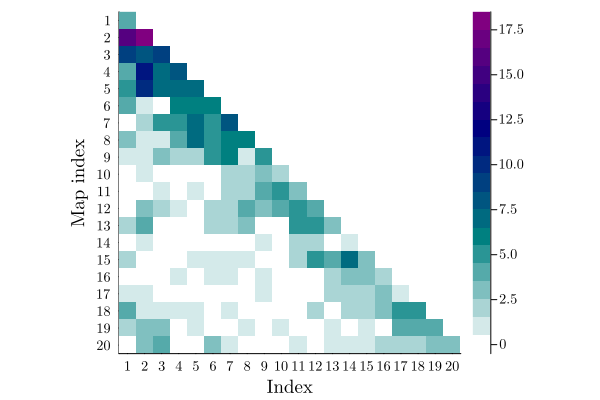

In [101]:
plot(S)
# savefig("Lorenz96_structure.pdf")

The function `hess_x_log_pdf!` computes in-place the Hessian of the log pdf of the pullback density $\boldsymbol{S}^{\sharp} \rho$. You can also use `hess_x_log_pdf`.

In [104]:
hess_x_log_pdf(S, X)

LoadError: BoundsError: attempt to access 500-element Vector{Float64} at index [501:1000]

In [105]:
function test_hess_x_log_pdf!(result, dcache, cache, C::HermiteMapComponent, X)
    NxX, Ne = size(X)
    Nx = C.Nx
    @show NxX, Nx
    @assert Nx == NxX "Wrong dimension of the sample"
    @assert size(result) == (Ne, NxX, NxX) "Wrong dimension of the result"

    # Compute hessian of log η∘C(x_{1:k}) with η the log pdf of N(O, I_n)
    evaluate!(cache, C, X)
    grad_x!(dcache, C.I, X)
    hess_x!(result, C.I, X)

    dim = active_dim(C)

    @inbounds for i=1:length(dim)
                for j=i:length(dim)
                dcachei = view(dcache,:,dim[i])
                dcachej = view(dcache,:,dim[j])
                resultij = view(result,:,dim[i],dim[j])
                resultji = view(result,:,dim[j], dim[i])
                resultij = resultij * cache + dcachei * dcachej
                resultji .= resultij
        end
    end

    rmul!(result, -1.0)

    # Compute hessian of log ∂k C(x_{1:k})
    cache .= grad_xd(C.I.f, X)
    cached2log = vhess_x_logeval(C.I.g, cache)
    dcache .= grad_x_grad_xd(C.I.f, X)

    @inbounds for i=1:length(dim)
                for j=i:length(dim)
                dcachei = view(dcache,:,dim[i])
                dcachej = view(dcache,:,dim[j])
                resultij = view(result,:,dim[i],dim[j])
                resultji = view(result,:,dim[j], dim[i])
                resultij += dcachei * dcachej * cached2log

                resultji .= resultij
        end
    end
    #
    grad_x_logeval!(cache, C.I.g, cache)
    result .+= hess_x_grad_xd(C.I.f, X) .* cache

    return result
end

test_hess_x_log_pdf! (generic function with 2 methods)

In [106]:
test_hess_x_log_pdf(C::HermiteMapComponent, X) = test_hess_x_log_pdf!(zeros(size(X,2), size(X,1), size(X,1)),
                                                     zeros(size(X,2), size(X,1)),
                                                     zeros(size(X,2)), C, X)



# This version outputs a result of size(Ne, active_dim(C), active_dim(C))


test_hess_x_log_pdf (generic function with 2 methods)

In [85]:
"""

Evaluates in-place the hessian of the logarithm of the pullback of the reference density (standard normal) by the map `M` for the ensemble matrix `X`.
"""
function test_hess_x_log_pdf!(result, M::HermiteMap, X; apply_rescaling::Bool = true)

        Nx = M.Nx
        NxX, Ne = size(X)
        @assert size(X,1) == Nx "Wrong dimension of the input vector"
        @assert size(result) == (Ne, Nx, Nx) "Wrong dimension of the result"
        # @assert size(cache_hess) == (Ne, Nx, Nx) "Wrong dimension of cache_hess"
        # @assert size(cache_grad) == (Ne, Nx) "Wrong dimension of cache_grad"
        # @assert size(cache) == (Ne, ) "Wrong dimension of cache"

        # We can apply the rescaling to all the components once
        if apply_rescaling == true
                transform!(M.L, X)
        end

        # The rescaling doesn't appears in the hessian, log(xy) = log(x) + log(y)
        @inbounds for i=1:Nx
                Xi = view(X,1:i,:)
#                 resulti = view(result,:,1:i,1:i)
#                 @show size(resulti)
                # cache_gradi = view(cache_grad,:,1:i)
                # cache_hessi = view(cache_hess,:,1:i,1:i)
                # hess_x_log_pdf!(cache_hessi, cache_gradi, cache, M.C[i], Xi)
                # @avx @. resulti += cache_hessi
                result[:, 1:i, 1:i] .+= hess_x_log_pdf(M[i], X[1:i,:])

        end

        if apply_rescaling == true
                itransform!(M.L, X)
        end

        return result
end

"""

Evaluates the hessian of the logarithm of the pullback of the reference density (standard normal) by the map `M` for the ensemble matrix `X`.
"""
test_hess_x_log_pdf(M::HermiteMap, X; apply_rescaling::Bool = true) = test_hess_x_log_pdf!(zeros(size(X,2), size(X,1), size(X,1)), M, X; apply_rescaling = apply_rescaling)

test_hess_x_log_pdf

In [114]:
dim = active_dim(S[3].I)
dimoff = dim[dim .< Nx]

3-element Vector{Int64}:
 1
 2
 3

┌ Error: Error watching manifest
│   exception =
│    MethodError: no method matching (::OpenSSL_jll.var"#make_wrapper_dict#6"{OpenSSL_jll.var"#parse_wrapper_platform#5"})(::String, ::Vector{String})
│    Stacktrace:
│     [1] top-level scope
│       @ ~/.julia/packages/JLLWrappers/QpMQW/src/toplevel_generators.jl:156
│    Revise evaluation error at /Users/mathieu/.julia/packages/JLLWrappers/QpMQW/src/toplevel_generators.jl:156
│    
│    Stacktrace:
│     [1] methods_by_execution!(recurse::Any, methodinfo::Revise.CodeTrackingMethodInfo, docexprs::Dict{Module, Vector{Expr}}, mod::Module, ex::Expr; mode::Symbol, disablebp::Bool, always_rethrow::Bool, kwargs::Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}})
│       @ Revise ~/.julia/packages/Revise/7HQ7u/src/lowered.jl:227
└ @ Revise ~/.julia/packages/Revise/7HQ7u/src/pkgs.jl:477
┌ Error: Error watching manifest
│   exception =
│    MethodError: no method matching (::OpenSSL_jll.var"#make_wrapper_dict#8"{OpenSSL_jll.var"#pa

In [111]:
for i=1:Nx
    @show i
    reduced_hess_x(S[i].I, X[1:i,:])
end

i = 1
i = 2
i = 3


LoadError: BoundsError: attempt to access 500-element Vector{Float64} at index [501:1000]

In [95]:
result = zeros(Ne, Nx, Nx)

@inbounds for i=1:Nx
    
        if i != 3
    #         Xi = view(X,1:i,:)
    #                 resulti = view(result,:,1:i,1:i)
    #                 @show size(resulti)
            # cache_gradi = view(cache_grad,:,1:i)
            # cache_hessi = view(cache_hess,:,1:i,1:i)
            # hess_x_log_pdf!(cache_hessi, cache_gradi, cache, M.C[i], Xi)
            # @avx @. resulti += cache_hessi
            @show i
            hess_x_log_pdf(S[i], X[1:i,:])
    end
end

i = 1
i = 2
i = 4
i = 5
i = 6
i = 7
i = 8
i = 9
i = 10
i = 11
i = 12
i = 13
i = 14
i = 15
i = 16


LoadError: BoundsError: attempt to access 500-element Vector{Float64} at index [501:1000]

In [86]:
test_hess_x_log_pdf(S, X)

LoadError: BoundsError: attempt to access 500-element Vector{Float64} at index [501:1000]

In [79]:
hess_x_log_pdf(S[4], X[1:4,:])

500×4×4 Array{Float64, 3}:
[:, :, 1] =
 -0.0484575  0.0382214  0.0446779  -0.133289
 -0.0490521  0.0384454  0.0446789  -0.133202
 -0.0484208  0.0383648  0.0447957  -0.133248
 -0.0488333  0.0378305  0.0448211  -0.133235
 -0.0485736  0.0381165  0.0451949  -0.133238
 -0.0485805  0.0383899  0.0447861  -0.133179
 -0.0486664  0.0380024  0.0448762  -0.133272
 -0.04843    0.0382629  0.0448091  -0.133285
 -0.0485938  0.0378482  0.0449948  -0.133308
 -0.0486788  0.0380367  0.0453308  -0.133269
 -0.0484696  0.0381819  0.044814   -0.133232
 -0.0486104  0.0380397  0.0452581  -0.133284
 -0.04902    0.0378485  0.0445566  -0.133172
  ⋮                                
 -0.0485253  0.0380369  0.0448997  -0.133246
 -0.0489375  0.03784    0.0446468  -0.133279
 -0.0490733  0.0383164  0.0446738  -0.13319
 -0.0489465  0.0385789  0.044782   -0.133178
 -0.0490655  0.0383453  0.0445453  -0.133238
 -0.049065   0.0380528  0.0448086  -0.133212
 -0.0489692  0.0381375  0.0449028  -0.133179
 -0.0484607  0.0382179  0.

In [40]:
Ωhat = zeros(Nx, Nx)
cache = zeros(Ne, Nx, Nx)
@showprogress for i=1:Ne
    hess_x_log_pdf!(cache, S, X[:,i:i])
    Ωhat .+= copy(cache[1,:,:]).^2
end
rmul!(Ωhat, 1/Ne)

LoadError: AssertionError: Wrong dimension of the result

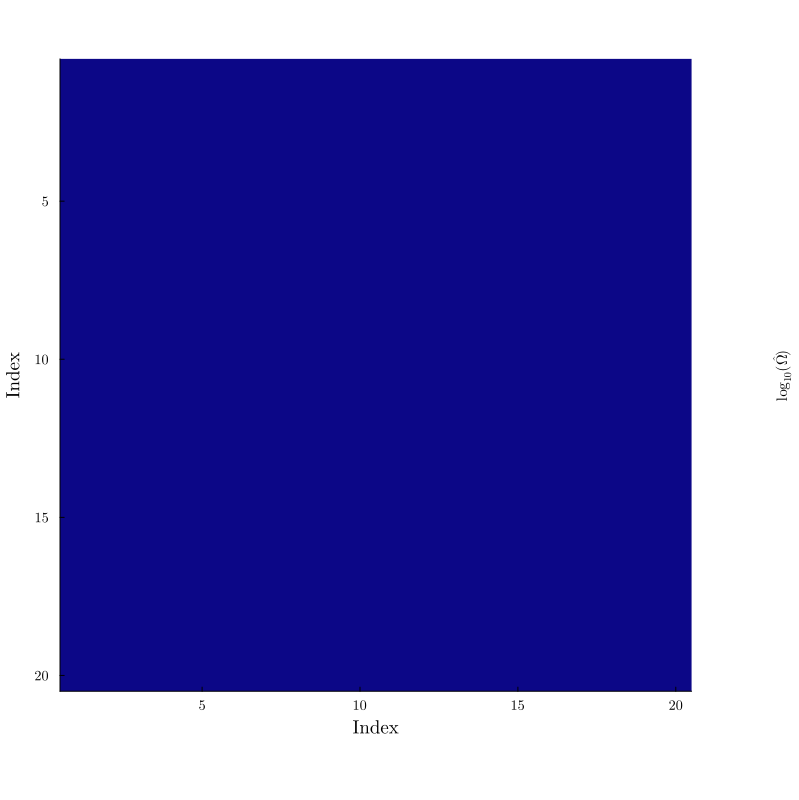

GKS: Rectangle definition is invalid in routine SET_WINDOW
GKS: Rectangle definition is invalid in routine CELLARRAY
invalid range
GKS: Rectangle definition is invalid in routine SET_WINDOW
GKS: Rectangle definition is invalid in routine CELLARRAY
invalid range
GKS: Rectangle definition is invalid in routine SET_WINDOW
GKS: Rectangle definition is invalid in routine CELLARRAY
invalid range


In [28]:
plt = plot(size = (800, 800))

heatmap!(plt,1:Nx, 1:Nx, log10.(Ωhat), ratio = 1, yflip = true, 
        colorbar = true, color = :plasma, clim = (1.5, Inf), colorbar_title = L"\log_{10}(\hat{\Omega})",
        xlabel = "Index", ylabel = "Index", background_color_inside = palette(:plasma)[1],
        ylims = (0.5,Nx+0.5))